## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-03-21 12:38:33--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  98.5MB/s    in 3.5s    

2021-03-21 12:38:37 (93.1 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.2)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.2)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((250, 250)),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

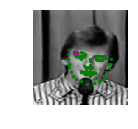

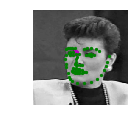

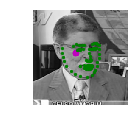

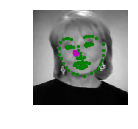

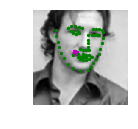

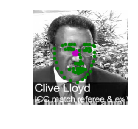

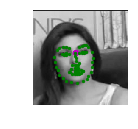

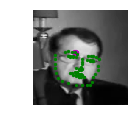

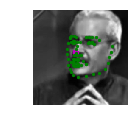

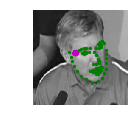

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2927177384495735
Epoch: 1, Batch: 20, Avg. Loss: 0.11932782977819442
Epoch: 1, Batch: 30, Avg. Loss: 0.11113537400960923
Epoch: 1, Batch: 40, Avg. Loss: 0.09336313605308533
Epoch: 1, Batch: 50, Avg. Loss: 0.11032407954335213
Epoch: 1, Batch: 60, Avg. Loss: 0.11407788321375847
Epoch: 1, Batch: 70, Avg. Loss: 0.10241835787892342
Epoch: 1, Batch: 80, Avg. Loss: 0.10390821844339371
Epoch: 1, Batch: 90, Avg. Loss: 0.10424973368644715
Epoch: 1, Batch: 100, Avg. Loss: 0.10356013104319572
Epoch: 1, Batch: 110, Avg. Loss: 0.10729239135980606
Epoch: 1, Batch: 120, Avg. Loss: 0.09057398699223995
Epoch: 1, Batch: 130, Avg. Loss: 0.10511922799050807
Epoch: 1, Batch: 140, Avg. Loss: 0.098135656863451
Epoch: 1, Batch: 150, Avg. Loss: 0.11870642453432083
Epoch: 1, Batch: 160, Avg. Loss: 0.1037607379257679
Epoch: 1, Batch: 170, Avg. Loss: 0.09563385769724846
Epoch: 1, Batch: 180, Avg. Loss: 0.09666574411094189
Epoch: 1, Batch: 190, Avg. Loss: 0.08951258137822152
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.09199663437902927
Epoch: 2, Batch: 20, Avg. Loss: 0.10446149632334709
Epoch: 2, Batch: 30, Avg. Loss: 0.10474619939923287
Epoch: 2, Batch: 40, Avg. Loss: 0.0928284615278244
Epoch: 2, Batch: 50, Avg. Loss: 0.09448397383093834
Epoch: 2, Batch: 60, Avg. Loss: 0.09679229408502579
Epoch: 2, Batch: 70, Avg. Loss: 0.1161531999707222
Epoch: 2, Batch: 80, Avg. Loss: 0.10234165042638779
Epoch: 2, Batch: 90, Avg. Loss: 0.10937688574194908
Epoch: 2, Batch: 100, Avg. Loss: 0.1059945397078991
Epoch: 2, Batch: 110, Avg. Loss: 0.08744684979319572
Epoch: 2, Batch: 120, Avg. Loss: 0.12234150320291519
Epoch: 2, Batch: 130, Avg. Loss: 0.10530542433261872
Epoch: 2, Batch: 140, Avg. Loss: 0.0939158134162426
Epoch: 2, Batch: 150, Avg. Loss: 0.09524995908141136
Epoch: 2, Batch: 160, Avg. Loss: 0.10477383360266686
Epoch: 2, Batch: 170, Avg. Loss: 0.1030440729111433
Epoch: 2, Batch: 180, Avg. Loss: 0.09666328430175782
Epoch: 2, Batch: 190, Avg. Loss: 0.10337953865528107
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.10491523742675782
Epoch: 3, Batch: 20, Avg. Loss: 0.11116145178675652
Epoch: 3, Batch: 30, Avg. Loss: 0.10211356990039348
Epoch: 3, Batch: 40, Avg. Loss: 0.09421350359916687
Epoch: 3, Batch: 50, Avg. Loss: 0.08942003585398198
Epoch: 3, Batch: 60, Avg. Loss: 0.10424945428967476
Epoch: 3, Batch: 70, Avg. Loss: 0.07273668684065342
Epoch: 3, Batch: 80, Avg. Loss: 0.09151951149106026
Epoch: 3, Batch: 90, Avg. Loss: 0.09520447552204132
Epoch: 3, Batch: 100, Avg. Loss: 0.08461696803569793
Epoch: 3, Batch: 110, Avg. Loss: 0.08791755512356758
Epoch: 3, Batch: 120, Avg. Loss: 0.09450762942433358
Epoch: 3, Batch: 130, Avg. Loss: 0.0853060394525528
Epoch: 3, Batch: 140, Avg. Loss: 0.10708149597048759
Epoch: 3, Batch: 150, Avg. Loss: 0.09527429416775704
Epoch: 3, Batch: 160, Avg. Loss: 0.08650216832756996
Epoch: 3, Batch: 170, Avg. Loss: 0.08712472170591354
Epoch: 3, Batch: 180, Avg. Loss: 0.08530431985855103
Epoch: 3, Batch: 190, Avg. Loss: 0.08668479472398757
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.08612782284617423
Epoch: 4, Batch: 20, Avg. Loss: 0.08853419162333012
Epoch: 4, Batch: 30, Avg. Loss: 0.08285834155976772
Epoch: 4, Batch: 40, Avg. Loss: 0.08537344262003899
Epoch: 4, Batch: 50, Avg. Loss: 0.08573403880000115
Epoch: 4, Batch: 60, Avg. Loss: 0.08546405993402004
Epoch: 4, Batch: 70, Avg. Loss: 0.07887668013572693
Epoch: 4, Batch: 80, Avg. Loss: 0.08721485733985901
Epoch: 4, Batch: 90, Avg. Loss: 0.0941936045885086
Epoch: 4, Batch: 100, Avg. Loss: 0.07595653235912322
Epoch: 4, Batch: 110, Avg. Loss: 0.08838115185499192
Epoch: 4, Batch: 120, Avg. Loss: 0.07805855050683022
Epoch: 4, Batch: 130, Avg. Loss: 0.08549832031130791
Epoch: 4, Batch: 140, Avg. Loss: 0.08394676297903061
Epoch: 4, Batch: 150, Avg. Loss: 0.09285277128219604
Epoch: 4, Batch: 160, Avg. Loss: 0.09072107486426831
Epoch: 4, Batch: 170, Avg. Loss: 0.08651134148240089
Epoch: 4, Batch: 180, Avg. Loss: 0.07747107483446598
Epoch: 4, Batch: 190, Avg. Loss: 0.0783758282661438
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.07874118611216545
Epoch: 5, Batch: 20, Avg. Loss: 0.07226849608123302
Epoch: 5, Batch: 30, Avg. Loss: 0.07908957116305829
Epoch: 5, Batch: 40, Avg. Loss: 0.09541411995887757
Epoch: 5, Batch: 50, Avg. Loss: 0.07389424629509449
Epoch: 5, Batch: 60, Avg. Loss: 0.08509916327893734
Epoch: 5, Batch: 70, Avg. Loss: 0.06804817058146
Epoch: 5, Batch: 80, Avg. Loss: 0.07394798249006271
Epoch: 5, Batch: 90, Avg. Loss: 0.08704699203372002
Epoch: 5, Batch: 100, Avg. Loss: 0.08319509886205197
Epoch: 5, Batch: 110, Avg. Loss: 0.07597117014229297
Epoch: 5, Batch: 120, Avg. Loss: 0.08865535408258438
Epoch: 5, Batch: 130, Avg. Loss: 0.07435429655015469
Epoch: 5, Batch: 140, Avg. Loss: 0.07655215300619603
Epoch: 5, Batch: 150, Avg. Loss: 0.07444023601710796
Epoch: 5, Batch: 160, Avg. Loss: 0.07743136249482632
Epoch: 5, Batch: 170, Avg. Loss: 0.07473460584878922
Epoch: 5, Batch: 180, Avg. Loss: 0.07569367960095405
Epoch: 5, Batch: 190, Avg. Loss: 0.06983085535466671
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.07126097977161408
Epoch: 6, Batch: 20, Avg. Loss: 0.07627009116113186
Epoch: 6, Batch: 30, Avg. Loss: 0.08017338737845421
Epoch: 6, Batch: 40, Avg. Loss: 0.07929145768284798
Epoch: 6, Batch: 50, Avg. Loss: 0.06927401274442672
Epoch: 6, Batch: 60, Avg. Loss: 0.06836455650627613
Epoch: 6, Batch: 70, Avg. Loss: 0.07061410695314407
Epoch: 6, Batch: 80, Avg. Loss: 0.06122261136770248
Epoch: 6, Batch: 90, Avg. Loss: 0.07487082891166211
Epoch: 6, Batch: 100, Avg. Loss: 0.07312680408358574
Epoch: 6, Batch: 110, Avg. Loss: 0.07677011489868164
Epoch: 6, Batch: 120, Avg. Loss: 0.07684842422604561
Epoch: 6, Batch: 130, Avg. Loss: 0.06137579046189785
Epoch: 6, Batch: 140, Avg. Loss: 0.07822793647646904
Epoch: 6, Batch: 150, Avg. Loss: 0.06620386615395546
Epoch: 6, Batch: 160, Avg. Loss: 0.0710840504616499
Epoch: 6, Batch: 170, Avg. Loss: 0.06233153119683266
Epoch: 6, Batch: 180, Avg. Loss: 0.0704504195600748
Epoch: 6, Batch: 190, Avg. Loss: 0.07103854939341545
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.07897126749157905
Epoch: 7, Batch: 20, Avg. Loss: 0.06469896733760834
Epoch: 7, Batch: 30, Avg. Loss: 0.06635516472160816
Epoch: 7, Batch: 40, Avg. Loss: 0.07536726295948029
Epoch: 7, Batch: 50, Avg. Loss: 0.06605328992009163
Epoch: 7, Batch: 60, Avg. Loss: 0.08650718480348588
Epoch: 7, Batch: 70, Avg. Loss: 0.05584777295589447
Epoch: 7, Batch: 80, Avg. Loss: 0.07148618958890438
Epoch: 7, Batch: 90, Avg. Loss: 0.06169400662183762
Epoch: 7, Batch: 100, Avg. Loss: 0.06594752334058285
Epoch: 7, Batch: 110, Avg. Loss: 0.061288855224847796
Epoch: 7, Batch: 120, Avg. Loss: 0.06473660245537757
Epoch: 7, Batch: 130, Avg. Loss: 0.06906329169869423
Epoch: 7, Batch: 140, Avg. Loss: 0.07259327098727227
Epoch: 7, Batch: 150, Avg. Loss: 0.06337367556989193
Epoch: 7, Batch: 160, Avg. Loss: 0.07417450584471226
Epoch: 7, Batch: 170, Avg. Loss: 0.062063655257225035
Epoch: 7, Batch: 180, Avg. Loss: 0.055683262273669244
Epoch: 7, Batch: 190, Avg. Loss: 0.05993087068200111

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.07372088693082332
Epoch: 8, Batch: 20, Avg. Loss: 0.05925418846309185
Epoch: 8, Batch: 30, Avg. Loss: 0.06423025131225586
Epoch: 8, Batch: 40, Avg. Loss: 0.06208864003419876
Epoch: 8, Batch: 50, Avg. Loss: 0.06256730556488037
Epoch: 8, Batch: 60, Avg. Loss: 0.06436510197818279
Epoch: 8, Batch: 70, Avg. Loss: 0.051975881680846214
Epoch: 8, Batch: 80, Avg. Loss: 0.05310848169028759
Epoch: 8, Batch: 90, Avg. Loss: 0.07089610919356346
Epoch: 8, Batch: 100, Avg. Loss: 0.0740774504840374
Epoch: 8, Batch: 110, Avg. Loss: 0.060402049124240874
Epoch: 8, Batch: 120, Avg. Loss: 0.05953349731862545
Epoch: 8, Batch: 130, Avg. Loss: 0.06108499504625797
Epoch: 8, Batch: 140, Avg. Loss: 0.06343382224440575
Epoch: 8, Batch: 150, Avg. Loss: 0.053639738634228704
Epoch: 8, Batch: 160, Avg. Loss: 0.0591106828302145
Epoch: 8, Batch: 170, Avg. Loss: 0.05818158276379108
Epoch: 8, Batch: 180, Avg. Loss: 0.05514675602316856
Epoch: 8, Batch: 190, Avg. Loss: 0.05439470820128918
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.05559610147029161
Epoch: 9, Batch: 20, Avg. Loss: 0.05863050296902657
Epoch: 9, Batch: 30, Avg. Loss: 0.06815808676183224
Epoch: 9, Batch: 40, Avg. Loss: 0.061980442702770235
Epoch: 9, Batch: 50, Avg. Loss: 0.05223545767366886
Epoch: 9, Batch: 60, Avg. Loss: 0.05569522343575954
Epoch: 9, Batch: 70, Avg. Loss: 0.059408978745341304
Epoch: 9, Batch: 80, Avg. Loss: 0.053949715197086336
Epoch: 9, Batch: 90, Avg. Loss: 0.06214309334754944
Epoch: 9, Batch: 100, Avg. Loss: 0.06146268993616104
Epoch: 9, Batch: 110, Avg. Loss: 0.05450671054422855
Epoch: 9, Batch: 120, Avg. Loss: 0.06721291318535805
Epoch: 9, Batch: 130, Avg. Loss: 0.05798698142170906
Epoch: 9, Batch: 140, Avg. Loss: 0.05734038501977921
Epoch: 9, Batch: 150, Avg. Loss: 0.05463932566344738
Epoch: 9, Batch: 160, Avg. Loss: 0.050183216109871864
Epoch: 9, Batch: 170, Avg. Loss: 0.04796043187379837
Epoch: 9, Batch: 180, Avg. Loss: 0.05512715317308903
Epoch: 9, Batch: 190, Avg. Loss: 0.0402002248913049

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.054493846371769905
Epoch: 10, Batch: 20, Avg. Loss: 0.05572606083005667
Epoch: 10, Batch: 30, Avg. Loss: 0.051606469228863715
Epoch: 10, Batch: 40, Avg. Loss: 0.0607511967420578
Epoch: 10, Batch: 50, Avg. Loss: 0.050890520215034485
Epoch: 10, Batch: 60, Avg. Loss: 0.05228392109274864
Epoch: 10, Batch: 70, Avg. Loss: 0.0428588530048728
Epoch: 10, Batch: 80, Avg. Loss: 0.04409764241427183
Epoch: 10, Batch: 90, Avg. Loss: 0.0508620323613286
Epoch: 10, Batch: 100, Avg. Loss: 0.05059615224599838
Epoch: 10, Batch: 110, Avg. Loss: 0.05541240274906158
Epoch: 10, Batch: 120, Avg. Loss: 0.045353982411324975
Epoch: 10, Batch: 130, Avg. Loss: 0.05053140819072723
Epoch: 10, Batch: 140, Avg. Loss: 0.040933442488312724
Epoch: 10, Batch: 150, Avg. Loss: 0.04122224021703005
Epoch: 10, Batch: 160, Avg. Loss: 0.043779473006725314
Epoch: 10, Batch: 170, Avg. Loss: 0.04786230642348528
Epoch: 10, Batch: 180, Avg. Loss: 0.04374997690320015
Epoch: 10, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.042151441983878615
Epoch: 11, Batch: 20, Avg. Loss: 0.04551175460219383
Epoch: 11, Batch: 30, Avg. Loss: 0.04612933099269867
Epoch: 11, Batch: 40, Avg. Loss: 0.042018702067434785
Epoch: 11, Batch: 50, Avg. Loss: 0.04250959772616625
Epoch: 11, Batch: 60, Avg. Loss: 0.04531225711107254
Epoch: 11, Batch: 70, Avg. Loss: 0.04279133211821318
Epoch: 11, Batch: 80, Avg. Loss: 0.03819358609616756
Epoch: 11, Batch: 90, Avg. Loss: 0.047401795908808705
Epoch: 11, Batch: 100, Avg. Loss: 0.04260849263519049
Epoch: 11, Batch: 110, Avg. Loss: 0.043885644525289536
Epoch: 11, Batch: 120, Avg. Loss: 0.051010983809828755
Epoch: 11, Batch: 130, Avg. Loss: 0.036928145587444304
Epoch: 11, Batch: 140, Avg. Loss: 0.04882000125944615
Epoch: 11, Batch: 150, Avg. Loss: 0.04051310494542122
Epoch: 11, Batch: 160, Avg. Loss: 0.04226958341896534
Epoch: 11, Batch: 170, Avg. Loss: 0.037184151634573934
Epoch: 11, Batch: 180, Avg. Loss: 0.04104850646108389
Epoch: 11, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.04333153124898672
Epoch: 12, Batch: 20, Avg. Loss: 0.04040859434753656
Epoch: 12, Batch: 30, Avg. Loss: 0.04160932749509812
Epoch: 12, Batch: 40, Avg. Loss: 0.043897039443254474
Epoch: 12, Batch: 50, Avg. Loss: 0.03975034914910793
Epoch: 12, Batch: 60, Avg. Loss: 0.04209648258984089
Epoch: 12, Batch: 70, Avg. Loss: 0.037221276015043256
Epoch: 12, Batch: 80, Avg. Loss: 0.038723324239253995
Epoch: 12, Batch: 90, Avg. Loss: 0.040881996415555476
Epoch: 12, Batch: 100, Avg. Loss: 0.039117038063704965
Epoch: 12, Batch: 110, Avg. Loss: 0.04501589443534613
Epoch: 12, Batch: 120, Avg. Loss: 0.03244863487780094
Epoch: 12, Batch: 130, Avg. Loss: 0.04377777148038149
Epoch: 12, Batch: 140, Avg. Loss: 0.03594280993565917
Epoch: 12, Batch: 150, Avg. Loss: 0.03556872084736824
Epoch: 12, Batch: 160, Avg. Loss: 0.03668246995657683
Epoch: 12, Batch: 170, Avg. Loss: 0.040750654973089696
Epoch: 12, Batch: 180, Avg. Loss: 0.04305044189095497
Epoch: 12, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.04063555859029293
Epoch: 13, Batch: 20, Avg. Loss: 0.039167063497006896
Epoch: 13, Batch: 30, Avg. Loss: 0.04653510395437479
Epoch: 13, Batch: 40, Avg. Loss: 0.04031799472868443
Epoch: 13, Batch: 50, Avg. Loss: 0.034280416741967204
Epoch: 13, Batch: 60, Avg. Loss: 0.03575933165848255
Epoch: 13, Batch: 70, Avg. Loss: 0.05108748450875282
Epoch: 13, Batch: 80, Avg. Loss: 0.03176075778901577
Epoch: 13, Batch: 90, Avg. Loss: 0.03691680990159511
Epoch: 13, Batch: 100, Avg. Loss: 0.03585625160485506
Epoch: 13, Batch: 110, Avg. Loss: 0.03328998927026987
Epoch: 13, Batch: 120, Avg. Loss: 0.036152522265911105
Epoch: 13, Batch: 130, Avg. Loss: 0.03323629703372717
Epoch: 13, Batch: 140, Avg. Loss: 0.04079968109726906
Epoch: 13, Batch: 150, Avg. Loss: 0.037135514058172704
Epoch: 13, Batch: 160, Avg. Loss: 0.044840427860617635
Epoch: 13, Batch: 170, Avg. Loss: 0.03921401146799326
Epoch: 13, Batch: 180, Avg. Loss: 0.03446598947048187
Epoch: 13, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.03220846932381392
Epoch: 14, Batch: 20, Avg. Loss: 0.03233059681952
Epoch: 14, Batch: 30, Avg. Loss: 0.036323640309274194
Epoch: 14, Batch: 40, Avg. Loss: 0.03582775071263313
Epoch: 14, Batch: 50, Avg. Loss: 0.03726764637976885
Epoch: 14, Batch: 60, Avg. Loss: 0.03572507109493017
Epoch: 14, Batch: 70, Avg. Loss: 0.03421694934368134
Epoch: 14, Batch: 80, Avg. Loss: 0.03668884560465813
Epoch: 14, Batch: 90, Avg. Loss: 0.038258522562682626
Epoch: 14, Batch: 100, Avg. Loss: 0.03680579774081707
Epoch: 14, Batch: 110, Avg. Loss: 0.04066953379660845
Epoch: 14, Batch: 120, Avg. Loss: 0.043329079449176786
Epoch: 14, Batch: 130, Avg. Loss: 0.03033239524811506
Epoch: 14, Batch: 140, Avg. Loss: 0.02830363754183054
Epoch: 14, Batch: 150, Avg. Loss: 0.04274509996175766
Epoch: 14, Batch: 160, Avg. Loss: 0.03108782973140478
Epoch: 14, Batch: 170, Avg. Loss: 0.036623156256973745
Epoch: 14, Batch: 180, Avg. Loss: 0.03679567351937294
Epoch: 14, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.03661240804940462
Epoch: 15, Batch: 20, Avg. Loss: 0.03559672888368368
Epoch: 15, Batch: 30, Avg. Loss: 0.031556876748800276
Epoch: 15, Batch: 40, Avg. Loss: 0.042560080997645855
Epoch: 15, Batch: 50, Avg. Loss: 0.035959722101688386
Epoch: 15, Batch: 60, Avg. Loss: 0.03198057617992163
Epoch: 15, Batch: 70, Avg. Loss: 0.028105147555470465
Epoch: 15, Batch: 80, Avg. Loss: 0.030861333757638932
Epoch: 15, Batch: 90, Avg. Loss: 0.044859864935278895
Epoch: 15, Batch: 100, Avg. Loss: 0.024849737621843816
Epoch: 15, Batch: 110, Avg. Loss: 0.024307029414922
Epoch: 15, Batch: 120, Avg. Loss: 0.02599715646356344
Epoch: 15, Batch: 130, Avg. Loss: 0.03658438958227635
Epoch: 15, Batch: 140, Avg. Loss: 0.03388340827077627
Epoch: 15, Batch: 150, Avg. Loss: 0.04229714907705784
Epoch: 15, Batch: 160, Avg. Loss: 0.03275454584509134
Epoch: 15, Batch: 170, Avg. Loss: 0.0358812365680933
Epoch: 15, Batch: 180, Avg. Loss: 0.029629868268966675
Epoch: 15, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0284429800696671
Epoch: 16, Batch: 20, Avg. Loss: 0.02968809399753809
Epoch: 16, Batch: 30, Avg. Loss: 0.02921253815293312
Epoch: 16, Batch: 40, Avg. Loss: 0.029311943240463732
Epoch: 16, Batch: 50, Avg. Loss: 0.03346765488386154
Epoch: 16, Batch: 60, Avg. Loss: 0.028238305635750294
Epoch: 16, Batch: 70, Avg. Loss: 0.029308753460645674
Epoch: 16, Batch: 80, Avg. Loss: 0.028161399625241758
Epoch: 16, Batch: 90, Avg. Loss: 0.031307459622621533
Epoch: 16, Batch: 100, Avg. Loss: 0.028599228151142596
Epoch: 16, Batch: 110, Avg. Loss: 0.0312106903642416
Epoch: 16, Batch: 120, Avg. Loss: 0.031044011749327183
Epoch: 16, Batch: 130, Avg. Loss: 0.029523224011063574
Epoch: 16, Batch: 140, Avg. Loss: 0.03000587746500969
Epoch: 16, Batch: 150, Avg. Loss: 0.03683488257229328
Epoch: 16, Batch: 160, Avg. Loss: 0.03472726196050644
Epoch: 16, Batch: 170, Avg. Loss: 0.03594560641795397
Epoch: 16, Batch: 180, Avg. Loss: 0.033994323946535586
Epoch: 16, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.03214779030531645
Epoch: 17, Batch: 20, Avg. Loss: 0.02846235204488039
Epoch: 17, Batch: 30, Avg. Loss: 0.025279978290200233
Epoch: 17, Batch: 40, Avg. Loss: 0.029335607402026655
Epoch: 17, Batch: 50, Avg. Loss: 0.037267296202480794
Epoch: 17, Batch: 60, Avg. Loss: 0.03203390464186669
Epoch: 17, Batch: 70, Avg. Loss: 0.033704578690230844
Epoch: 17, Batch: 80, Avg. Loss: 0.0315854724496603
Epoch: 17, Batch: 90, Avg. Loss: 0.028050572611391544
Epoch: 17, Batch: 100, Avg. Loss: 0.025022729486227035
Epoch: 17, Batch: 110, Avg. Loss: 0.024090550653636456
Epoch: 17, Batch: 120, Avg. Loss: 0.031355697009712455
Epoch: 17, Batch: 130, Avg. Loss: 0.033447458781301974
Epoch: 17, Batch: 140, Avg. Loss: 0.025627049524337052
Epoch: 17, Batch: 150, Avg. Loss: 0.025872227735817432
Epoch: 17, Batch: 160, Avg. Loss: 0.02951398305594921
Epoch: 17, Batch: 170, Avg. Loss: 0.0329750694334507
Epoch: 17, Batch: 180, Avg. Loss: 0.027720334567129613
Epoch: 17, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.02603748207911849
Epoch: 18, Batch: 20, Avg. Loss: 0.02475700033828616
Epoch: 18, Batch: 30, Avg. Loss: 0.030153588764369486
Epoch: 18, Batch: 40, Avg. Loss: 0.026419969089329243
Epoch: 18, Batch: 50, Avg. Loss: 0.028479212522506715
Epoch: 18, Batch: 60, Avg. Loss: 0.03185257352888584
Epoch: 18, Batch: 70, Avg. Loss: 0.03140917252749205
Epoch: 18, Batch: 80, Avg. Loss: 0.029639168456196786
Epoch: 18, Batch: 90, Avg. Loss: 0.02723324056714773
Epoch: 18, Batch: 100, Avg. Loss: 0.024701324477791785
Epoch: 18, Batch: 110, Avg. Loss: 0.03140830993652344
Epoch: 18, Batch: 120, Avg. Loss: 0.02537255398929119
Epoch: 18, Batch: 130, Avg. Loss: 0.025138549506664276
Epoch: 18, Batch: 140, Avg. Loss: 0.026988600753247736
Epoch: 18, Batch: 150, Avg. Loss: 0.026413016207516193
Epoch: 18, Batch: 160, Avg. Loss: 0.02871126066893339
Epoch: 18, Batch: 170, Avg. Loss: 0.024394324887543915
Epoch: 18, Batch: 180, Avg. Loss: 0.030023320205509664
Epoch: 18, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.02846135664731264
Epoch: 19, Batch: 20, Avg. Loss: 0.02732453355565667
Epoch: 19, Batch: 30, Avg. Loss: 0.0299972141161561
Epoch: 19, Batch: 40, Avg. Loss: 0.024883735924959183
Epoch: 19, Batch: 50, Avg. Loss: 0.025705260317772628
Epoch: 19, Batch: 60, Avg. Loss: 0.024488548375666143
Epoch: 19, Batch: 70, Avg. Loss: 0.026014668773859738
Epoch: 19, Batch: 80, Avg. Loss: 0.02455675844103098
Epoch: 19, Batch: 90, Avg. Loss: 0.024817254580557346
Epoch: 19, Batch: 100, Avg. Loss: 0.024134116992354394
Epoch: 19, Batch: 110, Avg. Loss: 0.030905858054757117
Epoch: 19, Batch: 120, Avg. Loss: 0.025235446356236934
Epoch: 19, Batch: 130, Avg. Loss: 0.033062778133898976
Epoch: 19, Batch: 140, Avg. Loss: 0.022280799318104984
Epoch: 19, Batch: 150, Avg. Loss: 0.03038102500140667
Epoch: 19, Batch: 160, Avg. Loss: 0.026551872491836548
Epoch: 19, Batch: 170, Avg. Loss: 0.022999951895326377
Epoch: 19, Batch: 180, Avg. Loss: 0.02606874369084835
Epoch: 19, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.02267542388290167
Epoch: 20, Batch: 20, Avg. Loss: 0.02540521286427975
Epoch: 20, Batch: 30, Avg. Loss: 0.02404576204717159
Epoch: 20, Batch: 40, Avg. Loss: 0.024037734884768725
Epoch: 20, Batch: 50, Avg. Loss: 0.0265973960980773
Epoch: 20, Batch: 60, Avg. Loss: 0.02232179269194603
Epoch: 20, Batch: 70, Avg. Loss: 0.026039943285286426
Epoch: 20, Batch: 80, Avg. Loss: 0.024258900340646504
Epoch: 20, Batch: 90, Avg. Loss: 0.022717502154409885
Epoch: 20, Batch: 100, Avg. Loss: 0.02634089346975088
Epoch: 20, Batch: 110, Avg. Loss: 0.023318210057914256
Epoch: 20, Batch: 120, Avg. Loss: 0.024685188196599483
Epoch: 20, Batch: 130, Avg. Loss: 0.023039207234978674
Epoch: 20, Batch: 140, Avg. Loss: 0.024105665273964405
Epoch: 20, Batch: 150, Avg. Loss: 0.02319199312478304
Epoch: 20, Batch: 160, Avg. Loss: 0.029030469339340927
Epoch: 20, Batch: 170, Avg. Loss: 0.023086033016443252
Epoch: 20, Batch: 180, Avg. Loss: 0.02166626965627074
Epoch: 20, Batch: 190, Avg. 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


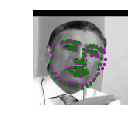

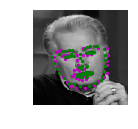

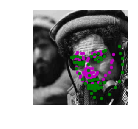

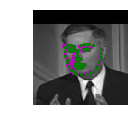

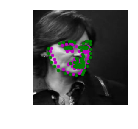

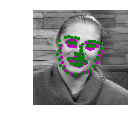

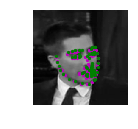

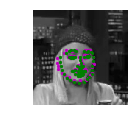

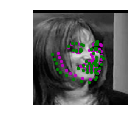

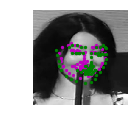

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'MostafasModel.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:
I chose Adam optimizer with, a learning rate of 0.0001, and the Mean Squared Error loss function which measured the Euclidean distance between points in the space. 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with a network similar to that of VGG-16 Architecture with some modifications to match the sizes needed in the following steps. I added dropout layers to avoid overfitting. And finally minimized the number of fully-connected layers.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: First, I tested the model on the default number of epochs which is one epoch on the default batch size. Then after adjusting it to 20 epochs, with a batch size of 16 (a power of two) results became much better.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.06068335  0.30996612 -0.08311874]
 [-0.22033417 -0.12188816 -0.16458006]
 [-0.0760828   0.13271143 -0.06291195]]
(3, 3)


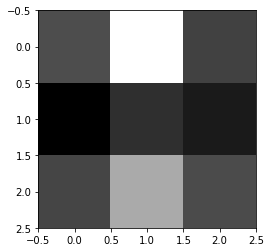

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

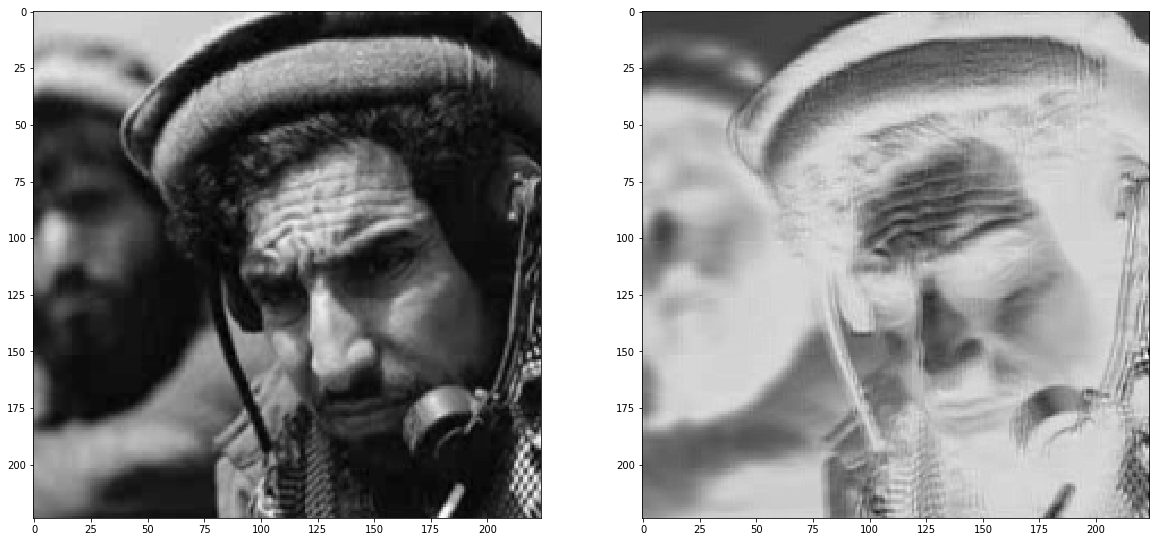

In [28]:
##TODO: load in and display any image from the transformed test dataset
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2

image = np.squeeze(test_images[2].data)
image = image.numpy()

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(image, cmap = "gray")

filter_index = 2
myFilter = w[filter_index][0]
filteredImage = cv2.filter2D(image, -1, myFilter)

ax2.imshow(filteredImage, cmap = "gray")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It detects horizontal edges.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!